Mean reversion strategie, koopt als hij onder de lage bollinger band zit en verkoopt dan als hij terug bij het gemiddelde is. Op dezelfde wijze verkoopt hij short als de prijs boven de hoge bollinger band is en hij sluit deze shortpositie als het gemiddelde weer berijkt is.

In [1]:
import pandas as pd
import numpy as np
import ta
import matplotlib.pyplot as plt
from tiingo import TiingoClient

In [1]:
config = {}
config['session'] = True
config['api_key'] =
#alpha vantage api key: 

client = TiingoClient(config)

SyntaxError: invalid syntax (2904601293.py, line 3)

In [3]:
class Backtest:
    
    def __init__(self, symbol):
        self.symbol = symbol
        frequency = "daily"
        data = client.get_ticker_price(symbol,
                                            fmt='json',
                                            startDate='2010-01-01',
                                            endDate='2022-6-1',
                                            frequency=frequency)
        self.df = pd.DataFrame(data)
        if self.df.empty:
            print("no data pulled")
        else:
            self.df['date'] = pd.to_datetime(self.df['date'])
            if frequency == 'daily':
                self.df['close'] = self.df['adjClose']
                self.df['open'] = self.df['adjOpen']
                self.df['high'] = self.df['adjHigh']
                self.df['low'] = self.df['adjLow']
            self.df.set_index('date', inplace=True)
            self.calc_indicators()
            self.generate_signals()
            self.match_signals()
            self.gains = self.calc_profit()
            self.cumul_gains = self.tdf.iloc[-1]['cumul_gains']
            self.max_dd = self.tdf['gains'].min() * 100

        
        
    def calc_indicators(self):
        self.df['ma_20'] = self.df.close.rolling(20).mean()
        self.df['volatility'] = self.df.close.rolling(20).std()
        self.df['upper_bb'] = self.df.ma_20 + (2 * self.df.volatility)
        self.df['lower_bb'] = self.df.ma_20 - (2 * self.df.volatility)
        self.df['atr'] = ta.volatility.AverageTrueRange(high=self.df.high, low=self.df.low, close=self.df.close, window=14, fillna=False).average_true_range()
        self.df.dropna(inplace=True)
    
    def generate_signals(self):
        conditions = [(self.df.close < self.df.lower_bb), (self.df.close > self.df.upper_bb)]
        choices = ['Long', 'Short']
        self.df['signal'] = np.select(conditions, choices)
        self.df.signal = self.df.signal.shift()
        
        exit_conditions = [(self.df.close > self.df.ma_20), (self.df.close < self.df.ma_20)]
        exit_choices = ['Long', 'Short']
        self.df['exit_signal'] = np.select(exit_conditions, exit_choices)
        self.df.exit_signal = self.df.exit_signal.shift()
        self.df.dropna(inplace=True)
    
    def match_signals(self):
        long = False
        short = False
        entrydates, exitdates = [],[]
        tradetypes = []
        self.tdf = pd.DataFrame()
        
        for index, row in self.df.iterrows():
            if not long and not short and row['signal'] == 'Long':
                long = True
                entrydates.append(index)
                buyprice = self.df.loc[index]['open']
                tradetypes.append("long")
            
            elif not long and not short and row['signal'] == 'Short':
                short = True
                entrydates.append(index)
                sellprice = self.df.loc[index]['open']
                tradetypes.append("short")
            
            elif long and row['exit_signal'] == 'Long':
                long = False
                exitdates.append(index)
            
            elif short and row['exit_signal'] == 'Short':
                short = False
                exitdates.append(index)
                
        if len(entrydates) > len(exitdates):
            entrydates = entrydates[:-1]
            tradetypes = tradetypes[:-1]
        self.tdf['entry_date'] = entrydates
        self.tdf['exit_date'] = exitdates
        self.tdf['trade_type'] = tradetypes
        self.tdf['entry_price'] = self.df.loc[entrydates].open.values
        self.tdf['exit_price'] = self.df.loc[exitdates].open.values
        self.tdf = self.tdf.set_index("exit_date")
        
    def calc_profit(self):
        gains = []
        for index, row in self.tdf.iterrows():
            if row['trade_type'] == 'long':
                gain = (row["exit_price"] - row["entry_price"])/row["entry_price"]
                gains.append(gain)
            elif row['trade_type'] == 'short':
                gain = (row["entry_price"] - row["exit_price"])/row["entry_price"]
                gains.append(gain)
        cumul_gains = []
        for i in range(len(gains)):
            if i == 0:
                cumul_gains.append(gains[i])
            else:
                cumul_gains.append((gains[i] + 1) * (cumul_gains[i-1] + 1) - 1)
        
        self.tdf['gains'] = gains
        self.tdf['cumul_gains'] = cumul_gains
        account_start = self.df.iloc[0]['open']
        
        # self.tdf['account_value'] = account_start * self.tdf['cumul_gains']
        # new_row = pd.DataFrame({'date':self.df.iloc[0].name, 'gains':1, 'cumul_gains':1, 'account_value':account_start}, index=[0]).set_index('date')
        
        self.account_value = pd.DataFrame(data={"account_value": account_start}, index=[self.df.iloc[0].name])
        new_addition = pd.DataFrame(data={'account_value': account_start*(self.tdf['cumul_gains'] + 1)}, index=self.tdf.index)
        self.account_value = pd.concat([self.account_value, new_addition])
        
#         self.account_value = account_start*(self.tdf['cumul_gains'] + 1)
#         self.account_value.loc[self.df.iloc[0].index] = account_start
        
        
    
    def plot_chart(self):
        self.account_value.plot(figsize=(20,6))
        self.df["close"].plot(figsize=(20,6))

In [4]:
ibm = Backtest("IBM")

In [6]:
ibm.cumul_gains

0.5211940814002214

<AxesSubplot:xlabel='date'>

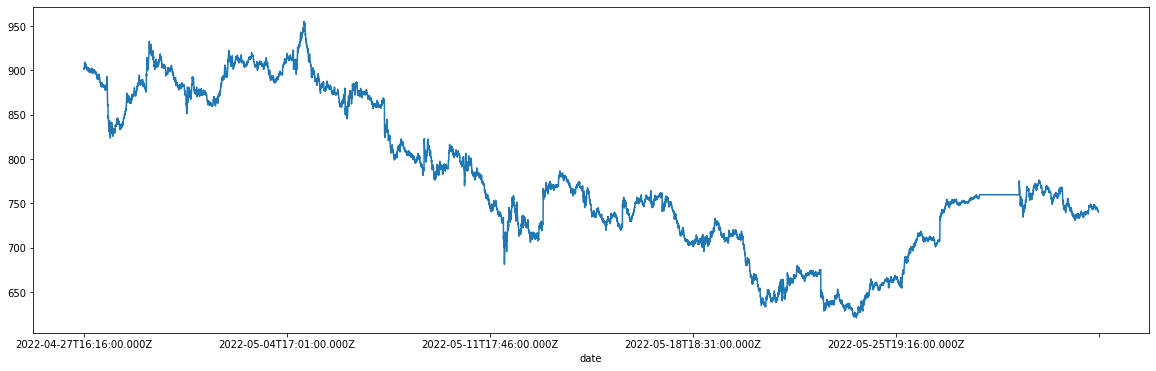

In [96]:
data = client.get_ticker_price("TSLA",
                                    fmt='json',
                                    startDate='2010-01-01',
                                    endDate='2022-6-1',
                                    frequency="1min")
df = pd.DataFrame(data).set_index('date')
df['close'].plot(figsize=(20,6))